<a href="https://colab.research.google.com/github/Sea370/DL_school/blob/master/Audio_signals_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install librosa

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import keras, keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

np.random.seed(42)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-06-10 10:32:59--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.246.9.175, 18.203.1.140, 34.243.191.39, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.246.9.175|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-06-10 10:32:59--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.24.18
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.24.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  96.8MB/s    in 4.5s    

2020-06-10 10:33:04 (92.4 MB/s) - ‘10256148’ saved [440207227/440207227]



In [ ]:
!unzip -q 10256148

In [ ]:
!pip install timit-utils

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=31c9f41d526e9493d613e975cc8ca596911b366e5c098504b86bf7895ac4f39a
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


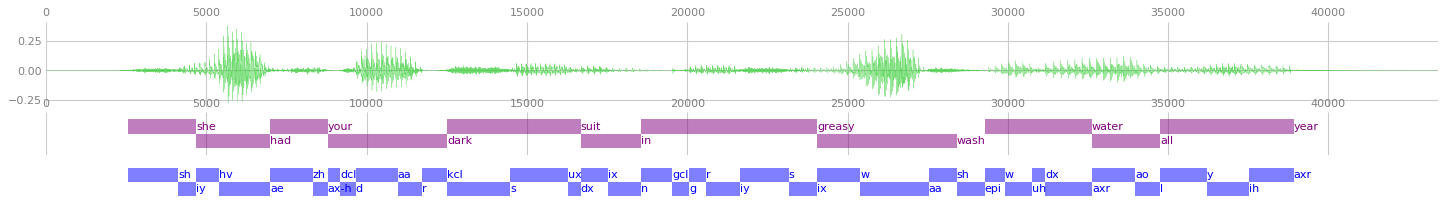

In [ ]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])
  

In [ ]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [ ]:
person_1 = corpus.test.person_by_index(150)

In [ ]:
IPython.display.Audio(person_1.sentence_by_index(1).raw_audio, rate=16000)

In [ ]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [ ]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [ ]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [ ]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)

In [ ]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [ ]:
trainset = create_dataset('train')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train_in, X_val_in, y_train_in, y_val_in = train_test_split(X, y, random_state=42)

In [ ]:
testset = create_dataset('test')
X_test_in, y_test_in = map(np.stack, zip(*testset))
X_test_in= X_test_in.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


**ЭТАП 1. Улучшаем скор.**

На этом этапе рассмотрим модели с 1D и 2D свертками.

**Первая модель - Conv1D:**

In [ ]:
X_train = X_train_in
X_val = X_val_in
X_test = X_test_in

y_train = y_train_in
y_val = y_val_in
y_test = y_test_in

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((3000, 150, 128), (1000, 150, 128), (1500, 150, 128))

In [ ]:
import keras, keras.layers
from tensorflow.keras import regularizers

In [ ]:
model1D = keras.models.Sequential([
    
    keras.layers.InputLayer(input_shape=(None, 128)), 
    
    keras.layers.Conv1D(32, kernel_size=4),
    keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(axis=2),
    keras.layers.Dropout(0.1),

    keras.layers.Conv1D(64, kernel_size=4),
    keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(axis=2),

    keras.layers.Conv1D(128, kernel_size=4),
    keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(axis=2),

    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation='softmax')
])
model1D.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, None, 32)          16416     
_________________________________________________________________
activation_19 (Activation)   (None, None, 32)          0         
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 32)          128       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
activation_20 (Activation)   (None, None, 64)          0         
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 64)         

In [ ]:
#Conv1D

def RunConv1D(model=model1D):

  initial_learning_rate = 1e-3

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.9,
      staircase=True)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
            loss ='sparse_categorical_crossentropy',
            metrics = ['sparse_categorical_accuracy'])
  model.fit(X_train, y_train, batch_size=100, epochs=60, validation_data = [X_val, y_val]) 

In [ ]:
RunConv1D()

Train on 3000 samples, validate on 1000 samples
Epoch 1/60
3000/3000 [==============================] - 1s 283us/step - loss: 0.3631 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.5704 - val_sparse_categorical_accuracy: 0.6820
Epoch 2/60
3000/3000 [==============================] - 0s 158us/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.7400
Epoch 3/60
3000/3000 [==============================] - 0s 151us/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.4602 - val_sparse_categorical_accuracy: 0.7820
Epoch 4/60
3000/3000 [==============================] - 0s 146us/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.9440
Epoch 5/60
3000/3000 [==============================] - 0s 149us/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.6891 - val_sparse_categorical_accuracy: 0.6510
Epoch 6/60
3000/3000 [==========

In [ ]:
#Conv1D

def PredictConv1D(X_test, y_test, model=model1D):

  y_pred = model.predict_classes(X_test)

  return accuracy_score(y_pred, y_test)

In [ ]:
PredictConv1D(X_test, y_test)

0.99

Для получения данного скора - 0.99, модель (baseline) была усовершенствована следующим образом: добавлен batchnorm, выбран оптимизатор Adam c экспоненциально уменьшающимся lr, обучение проводилось на 60-ти эпохах, это оказалось оптимально. Данная модель обучается очень быстро.

**Вторая модель - Conv2D:**

In [ ]:
#Решейп данных для Conv2D модели:

def ReshapeConv2D_train(X_train, X_val):
  
  X_train = np.expand_dims(X_train_in, axis=3)
  X_val = np.expand_dims(X_val_in, axis=3)

  return X_train, X_val

def ReshapeConv2D_test(X_test):

  return np.expand_dims(X_test_in, axis=3)

X_train, X_val = ReshapeConv2D_train(X_train_in, X_val_in)

X_test = ReshapeConv2D_test(X_test_in)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((3000, 150, 128, 1), (1000, 150, 128, 1), (1500, 150, 128, 1))

In [ ]:
model2D = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(150, 128, 1)), 
    
    keras.layers.Conv2D(32, kernel_size=(3, 3)),
    #keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(64, kernel_size=(3, 3)),
    #keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),

    keras.layers.Conv2D(128, kernel_size=(3, 3)),
    #keras.layers.BatchNormalization(axis=3),
    #keras.layers.MaxPooling2D((2, 2)), 
    keras.layers.Activation('relu'),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(2, activation='softmax')
])
model2D.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 126, 32)      320       
_________________________________________________________________
activation_22 (Activation)   (None, 148, 126, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 148, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 124, 64)      18496     
_________________________________________________________________
activation_23 (Activation)   (None, 146, 124, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 122, 128)     73856     
_________________________________________________________________
activation_24 (Activation)   (None, 144, 122, 128)    

In [ ]:
#Conv2D

def RunConv2D(model=model2D):

  initial_learning_rate = 1e-2
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.9,
      staircase=True)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
            loss ='sparse_categorical_crossentropy',
            metrics = ['sparse_categorical_accuracy'])
  model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data = [X_val, y_val]) 

In [ ]:
RunConv2D()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.6261 - val_sparse_categorical_accuracy: 0.6820
Epoch 2/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.6143 - val_sparse_categorical_accuracy: 0.6830
Epoch 3/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5681 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.5093 - val_sparse_categorical_accuracy: 0.7120
Epoch 4/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4001 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.8820
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.2848 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.2706 - val_sparse_categorical_accuracy: 0.9430
Epoch 6/30
3000/3000 [===============

In [ ]:
#Conv2D

def PredictConv2D(X_test, y_test, model=model2D):

  y_pred = model.predict_classes(X_test)

  return accuracy_score(y_pred, y_test)

PredictConv2D(X_test, y_test)

0.9613333333333334

**Описание результатов:** 

Скор первой модели Conv1D - 0,99. 

Вторая модель пока что показывает менее впечатляющие результаты, скор - 0,96.



**ЭТАП 2. Портим данные**

In [ ]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

import nlpaug
nlpaug.__version__

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-x9lpkkb2
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-x9lpkkb2
  Created wheel for nlpaug: filename=nlpaug-0.0.14-cp36-none-any.whl size=583433 sha256=eb0d9278ed5228c969183817ed8f337a59f3d2fcc29aa1f35742fb1c80c5eeb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jx7i32t2/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


'0.0.14'

In [ ]:
import nlpaug.augmenter.audio as naa

import librosa.display as librosa_display
import matplotlib.pyplot as plt

In [ ]:
data = person_1.sentence_by_index(1).raw_audio

sr = 16000

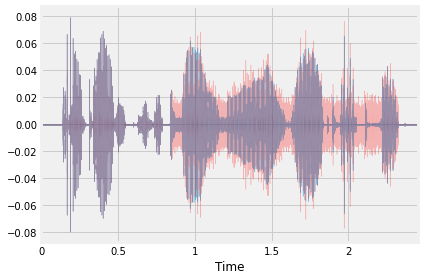

In [ ]:
aug = naa.NoiseAug()

augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

IPython.display.Audio(augmented_data, rate=16000)

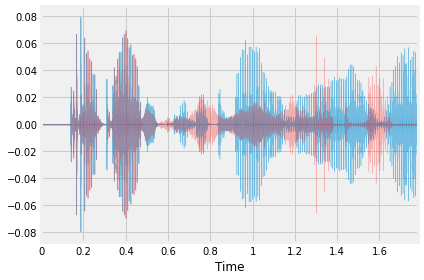

In [ ]:
aug = naa.SpeedAug()
augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

IPython.display.Audio(augmented_data, rate=16000)


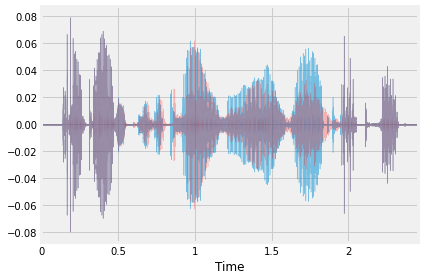

In [ ]:

aug = naa.PitchAug(sampling_rate=sr, factor=(-10,10))
augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()


IPython.display.Audio(augmented_data, rate=16000)


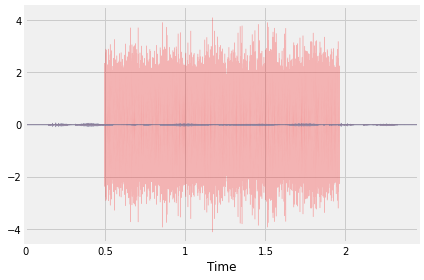

In [ ]:
aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=True)
augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

IPython.display.Audio(augmented_data, rate=16000)


Выберем несколько вариантов к-рые могут хорошо испортить данные: добавление шума, изменение скорости, сдвиг частот, маска с добавлением шума и тп. и выбирая их случайным образом, испортим тестовый набор.

In [ ]:
import random
random.seed(42)

def create_spoiled_dataset():

  spoiled = [naa.NoiseAug(),
             naa.SpeedAug(), 
             naa.PitchAug(sampling_rate=sr, factor=(-10,10)), 
             naa.MaskAug(sampling_rate=sr, mask_with_noise=True)]

  people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(random.choice(spoiled).augment(person.sentence_by_index(i).raw_audio), target))
  return spectrograms_and_targets

In [ ]:
testset = create_spoiled_dataset()
X_test_sp1, y_test_sp1 = map(np.stack, zip(*testset))
X_test_sp1 = X_test_sp1.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [ ]:
#Conv1D 

PredictConv1D(X_test_sp1, y_test_sp1)


0.8286666666666667

In [ ]:
#Conv2D

X_test = ReshapeConv2D_test(X_test_sp1)

y_test = y_test_sp1

PredictConv2D(X_test, y_test)

0.9613333333333334

Мы видим что у Conv1D скор неcколько упал, а у Conv2D, скор вообще практически не изменился.

**3 ЭТАП. Улучшение моделей**

Применим аналогичные аугментации к половине тренировочного набора (вторую половину оставим без изменений) и попробуем на нём обучиться, посмотрим какие будут результаты после этого.

In [ ]:
import random
random.seed(42)

sr = 16000

def create_augmented_dataset():

  augm = [naa.NoiseAug(),
          naa.SpeedAug(), 
          naa.PitchAug(sampling_rate=sr, factor=(-10,10)), 
          naa.MaskAug(sampling_rate=sr, mask_with_noise=True)]

  people = [corpus.train.person_by_index(i) for i in range(400)]

  spectrograms_and_targets = []

  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      
      p = random.uniform(0, 1)

      if p <= 0.5:

        spectrograms_and_targets.append(preprocess_sample(random.choice(augm).augment(person.sentence_by_index(i).raw_audio), target))

      else:

        spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))

  
  return spectrograms_and_targets


In [ ]:
trainset = create_augmented_dataset()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train_im, X_val_im, y_train_im, y_val_im = train_test_split(X, y, random_state=42)

In [ ]:
X_train = X_train_im
X_val = X_val_im

y_train = y_train_im
y_val = y_val_im

RunConv1D()

Train on 3000 samples, validate on 1000 samples
Epoch 1/60
3000/3000 [==============================] - 1s 319us/step - loss: 0.2812 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.3683 - val_sparse_categorical_accuracy: 0.8880
Epoch 2/60
3000/3000 [==============================] - 0s 160us/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.3285 - val_sparse_categorical_accuracy: 0.8790
Epoch 3/60
3000/3000 [==============================] - 0s 160us/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9130
Epoch 4/60
3000/3000 [==============================] - 0s 160us/step - loss: 0.0761 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.1469 - val_sparse_categorical_accuracy: 0.9560
Epoch 5/60
3000/3000 [==============================] - 0s 157us/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.1622 - val_sparse_categorical_accuracy: 0.9520
Epoch 6/60
3000/3000 [==========

In [ ]:
PredictConv1D(X_test_sp1, y_test_sp1)

0.932

Скор снова несколько вырос



In [ ]:
#Посмотрим на результаты Conv2D модели:

X_train, X_val = ReshapeConv2D_train(X_train_im, X_val_im)

y_train = y_train_im
y_val = y_val_im

RunConv2D()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0893 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0869 - val_sparse_categorical_accuracy: 0.9700
Epoch 2/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.1439 - val_sparse_categorical_accuracy: 0.9730
Epoch 3/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0894 - val_sparse_categorical_accuracy: 0.9740
Epoch 4/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0827 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.0928 - val_sparse_categorical_accuracy: 0.9730
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9660
Epoch 6/30
3000/3000 [===============

In [ ]:
X_test = ReshapeConv2D_test(X_test_sp1)

y_test = y_test_sp1

PredictConv2D(X_test, y_test)

0.9653333333333334

Модель Conv2D с обучением на агментациях показала на испорченных данных даже немного лучший результат, чем на чистом трейне.

**Попробуем что можно сделать с предобученными моделями из Imagenet:**

In [ ]:
from keras.applications import ResNet50V2

In [ ]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 128, 3),
    pooling='avg'
    )

In [ ]:
#resnet.layers[-1:]

In [ ]:

model_resnet = keras.models.Sequential([
                                       
    resnet,
    
    keras.layers.Dense(2, activation='softmax')
])

model_resnet.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 4098      
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
#Решейп данных для модели и делаем три одинаковых канала:

def ReshapeResnet_train(X_train, X_val):
  
  X_train = np.swapaxes(np.expand_dims(X_train, axis=3), 3, 2)                      
  X_val = np.swapaxes(np.expand_dims(X_val, axis=3), 3, 2)

  X_train = np.dstack([X_train]*3)
  X_val = np.dstack([X_val]*3)

  X_train = np.swapaxes(X_train, 3, 2)                      
  X_val = np.swapaxes(X_val, 3, 2)
  
  return X_train, X_val

def ReshapeResnet_test(X_test):

  X_test = np.swapaxes(np.expand_dims(X_test, axis=3), 3, 2)
  X_test = np.dstack([X_test]*3)
  X_test = np.swapaxes(X_test, 3, 2)

  return X_test

In [ ]:
X_train, X_val = ReshapeResnet_train(X_train_in, X_val_in)

X_test = ReshapeResnet_test(X_test_in)

y_train = y_train_in
y_val = y_val_in

y_test = y_test_in

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((3000, 150, 128, 3), (1000, 150, 128, 3), (1500, 150, 128, 3))

In [ ]:
def RunResnet(model=model_resnet):
  initial_learning_rate = 1e-5
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=100000,
  decay_rate=0.9,
  staircase=True)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
          loss ='sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
  model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data = [X_val, y_val]) 

In [ ]:
RunResnet()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6773 - sparse_categorical_accuracy: 0.6453 - val_loss: 0.6996 - val_sparse_categorical_accuracy: 0.5880
Epoch 2/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.4984 - sparse_categorical_accuracy: 0.7813 - val_loss: 0.7544 - val_sparse_categorical_accuracy: 0.6670
Epoch 3/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.8373 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.6770
Epoch 4/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.2632 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.6470
Epoch 6/30
3000/3000 [==============

Результаты модели с применением предобученной Resnet50V2:

In [ ]:
#Результат на "чистых" данных:

def PredictResnet(X_test, y_test, model=model_resnet):

  y_pred = model.predict_classes(X_test)

  return accuracy_score(y_pred, y_test)

PredictResnet(X_test, y_test)

0.9473333333333334

In [ ]:
#Результаты на "испорченных" данных (набор аугментаций):

X_test = ReshapeResnet_test(X_test_sp1)

y_test = y_test_sp1

PredictResnet(X_test, y_test)

0.7653333333333333

In [ ]:
#Улучшаем модель за счёт аугментаций на трейне

X_train, X_val = ReshapeResnet_train(X_train_im, X_val_im)

y_train = y_train_im
y_val = y_val_im

RunResnet()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5211 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.8958 - val_sparse_categorical_accuracy: 0.7010
Epoch 2/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.2334 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.7134 - val_sparse_categorical_accuracy: 0.7240
Epoch 3/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1559 - sparse_categorical_accuracy: 0.9393 - val_loss: 0.5776 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9577 - val_loss: 0.4948 - val_sparse_categorical_accuracy: 0.7960
Epoch 5/30
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.4358 - val_sparse_categorical_accuracy: 0.8230
Epoch 6/30
3000/3000 [==============

In [ ]:
#Результаты после улучшения на "испорченных" данных (набор аугментаций):

X_test = ReshapeResnet_test(X_test_sp1)

y_test = y_test_sp1

PredictResnet(X_test, y_test)

0.8086666666666666

**4 ЭТАП. Сравнение моделей, выводы.**

In [ ]:
import pandas as pd

#Сравнение результатов моделей:

models = ['Conv1D', 'Conv2D', 'Resnet50V2']
results = {
    'Accuracy_score_intitial': [ 0.99, 0.96, 0.94],
    'Accuracy_score_spoiled': [ 0.83, 0.96, 0.77],
    'Accuracy_score_improved':  [ 0.93, 0.97, 0.81],
    }
res = pd.DataFrame(data=results, index=models)
res

,Accuracy_score_intitial,Accuracy_score_spoiled,Accuracy_score_improved
Conv1D,0.99,0.83,0.93
Conv2D,0.96,0.96,0.97
Resnet50V2,0.94,0.77,0.81
